In [2]:
import matplotlib.pyplot as plt
import numpy as np
import flet as ft
import os
from pylsl import StreamInlet, resolve_stream
from scipy.signal import welch, spectrogram
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import pandas as pd
from joblib import dump, load
import pyxdf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

Authorization classes are not loaded, using fake implementations.


In [3]:
# Combine all data stored in the same folder to use for training the model.
def concat_data(frequency):
    data_folder = f'../../../../data_ssvep/Toey/SSVEP_data/test/{frequency}'
    all_data = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        streams, _ = pyxdf.load_xdf(file_path)
        raw_data = streams[0]["time_series"].T
        all_data.append(raw_data)
    all_data_array = np.concatenate(all_data, axis=1)
    return all_data_array


In [4]:
def create_overlapping_sets(data, set_size=500, overlap_fraction=0.5):
    step = int(set_size * (1 - overlap_fraction))
    sets = []
    for i in range(0, len(data) - set_size + 1, step):
        sets.append(data[i:i + set_size])
    return sets

In [7]:
raw_test1 = concat_data('6Hz')
print(raw_test1[0:4,:].shape)
raw_test2 = concat_data('20Hz')
print(raw_test2[0:4,:].shape)
raw_test3 = concat_data('0Hz')
print(raw_test3[0:4,:].shape)

(4, 15150)
(4, 13140)
(4, 15150)


In [6]:
set_size=1000
overlap_fraction=0.5
data_test1 = raw_test1[0:4,:]
data_test1_oz = data_test1[0] - data_test1[1]
data_test1_o1 = data_test1[2] - data_test1[1]
data_test1_o2 = data_test1[3] - data_test1[1]
data_test1_set_oz = create_overlapping_sets(data_test1_oz, set_size=set_size, overlap_fraction=overlap_fraction)
data_test1_set_o1 = create_overlapping_sets(data_test1_o1, set_size=set_size, overlap_fraction=overlap_fraction)
data_test1_set_o2 = create_overlapping_sets(data_test1_o2, set_size=set_size, overlap_fraction=overlap_fraction)
data_test1_fft_oz = []
data_test1_fft_o2 = []
data_test1_fft_o1 = []
for i in range(len(data_test1_set_oz)):
    f, Pxx = welch(data_test1_set_oz[i], fs=250, nperseg= 250*4)
    data_test1_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data_test1_set_o1[i], fs=250, nperseg= 250*4)
    data_test1_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data_test1_set_o2[i], fs=250, nperseg= 250*4)
    data_test1_fft_o2.append(Pxx[0:121])

combined_test1 = np.hstack((data_test1_fft_oz, data_test1_fft_o1, data_test1_fft_o2))
data_test2 = raw_test2[0:4,:]
data_test2_oz = data_test2[0] - data_test2[1]
data_test2_o1 = data_test2[2] - data_test2[1]
data_test2_o2 = data_test2[3] - data_test2[1]
data_test2_set_oz = create_overlapping_sets(data_test2_oz, set_size=set_size, overlap_fraction=overlap_fraction)
data_test2_set_o1 = create_overlapping_sets(data_test2_o1, set_size=set_size, overlap_fraction=overlap_fraction)
data_test2_set_o2 = create_overlapping_sets(data_test2_o2, set_size=set_size, overlap_fraction=overlap_fraction)
data_test2_fft_oz = []
data_test2_fft_o2 = []
data_test2_fft_o1 = []
for i in range(len(data_test2_set_oz)):
    f, Pxx = welch(data_test2_set_oz[i], fs=250, nperseg= 250*4)
    data_test2_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data_test2_set_o1[i], fs=250, nperseg= 250*4)
    data_test2_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data_test2_set_o2[i], fs=250, nperseg= 250*4)
    data_test2_fft_o2.append(Pxx[0:121])

combined_test2 = np.hstack((data_test2_fft_oz, data_test2_fft_o1, data_test2_fft_o2))

data_test3 = raw_test3[0:4,:]
data_test3_oz = data_test3[0] - data_test3[1]
data_test3_o1 = data_test3[2] - data_test3[1]
data_test3_o2 = data_test3[3] - data_test3[1]
data_test3_set_oz = create_overlapping_sets(data_test3_oz, set_size=set_size, overlap_fraction=overlap_fraction)
data_test3_set_o1 = create_overlapping_sets(data_test3_o1, set_size=set_size, overlap_fraction=overlap_fraction)
data_test3_set_o2 = create_overlapping_sets(data_test3_o2, set_size=set_size, overlap_fraction=overlap_fraction)
data_test3_fft_oz = []
data_test3_fft_o2 = []
data_test3_fft_o1 = []
for i in range(len(data_test3_set_oz)):
    f, Pxx = welch(data_test3_set_oz[i], fs=250, nperseg= 250*4)
    data_test3_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data_test3_set_o1[i], fs=250, nperseg= 250*4)
    data_test3_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data_test3_set_o2[i], fs=250, nperseg= 250*4)
    data_test3_fft_o2.append(Pxx[0:121])

combined_test3 = np.hstack((data_test3_fft_oz, data_test3_fft_o1, data_test3_fft_o2))

combined_test = np.vstack((combined_test1, combined_test2, combined_test3))
labels_test = np.array([0]*len(data_test1_fft_oz) + [1]*len(data_test2_fft_oz) + [2]*len(data_test3_fft_oz))
print(combined_test.shape)
print(labels_test.shape)
print(len(data_test1_fft_oz),len(data_test2_fft_oz),len(data_test3_fft_oz))

(83, 363)
(83,)
29 25 29


In [9]:
rf_model = load("../final/model_FFT/best_rf_classifier_youtube.joblib")
svm_model = load("../final/model_FFT/best_svm_classifier_youtube.joblib")
lda_model = load("../final/model_FFT/best_lda_classifier_youtube.joblib")
knn_model = load("../final/model_FFT/best_knn_classifier_youtube.joblib")

In [10]:
y_pred_rf_test = rf_model.predict(combined_test)
y_pred_svm_test = svm_model.predict(combined_test)
y_pred_lda_test = lda_model.predict(combined_test)
y_pred_knn_test = knn_model.predict(combined_test)

Evaluation metrics for Random Forest:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   1.000000  0.965517  0.982456  1.000000
1          1.0   0.961538  1.000000  0.980392  0.961538
2          2.0   1.000000  1.000000  1.000000  1.000000
average    NaN   0.988415  0.987952  0.987964  0.987179

[[28  1  0]
 [ 0 25  0]
 [ 0  0 29]]


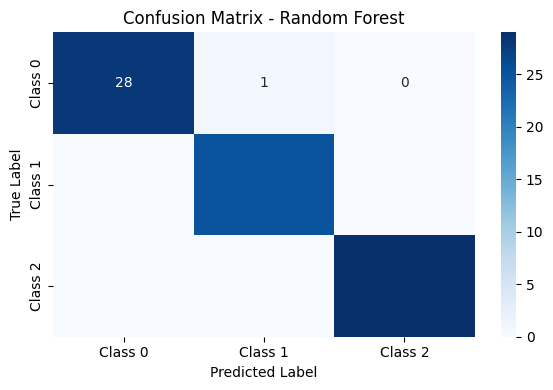

Evaluation metrics for SVM:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.805556  1.000000  0.892308  0.805556
1          1.0   1.000000  0.720000  0.837209  1.000000
2          2.0   1.000000  1.000000  1.000000  1.000000
average    NaN   0.932062  0.915663  0.913339  0.935185

[[29  0  0]
 [ 7 18  0]
 [ 0  0 29]]


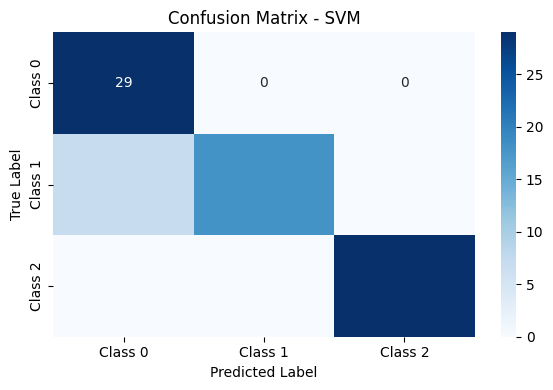

Evaluation metrics for LDA:
         Class  Precision  Recall  F1-score  Accuracy
0          0.0        1.0     1.0       1.0       1.0
1          1.0        1.0     1.0       1.0       1.0
2          2.0        1.0     1.0       1.0       1.0
average    NaN        1.0     1.0       1.0       1.0

[[29  0  0]
 [ 0 25  0]
 [ 0  0 29]]


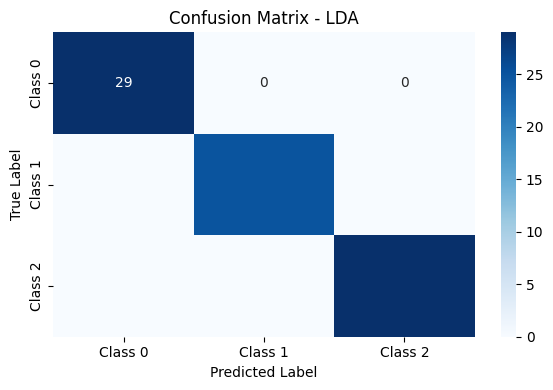

Evaluation metrics for KNN:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.828571  1.000000  0.906250  0.828571
1          1.0   1.000000  0.760000  0.863636  1.000000
2          2.0   1.000000  1.000000  1.000000  1.000000
average    NaN   0.940103  0.927711  0.926171  0.942857

[[29  0  0]
 [ 6 19  0]
 [ 0  0 29]]


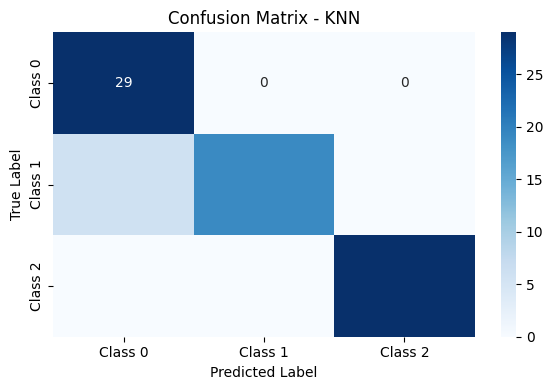

In [11]:
# Define the models and their predictions
models = ['Random Forest', 'SVM', 'LDA', 'KNN']
y_preds = [y_pred_rf_test, y_pred_svm_test, y_pred_lda_test, y_pred_knn_test]

for model, y_pred in zip(models, y_preds):
    # Calculate precision, recall, F1-score, and accuracy per class
    precision_per_class = precision_score(labels_test, y_pred, average=None)
    recall_per_class = recall_score(labels_test, y_pred, average=None)
    f1_per_class = f1_score(labels_test, y_pred, average=None)

    # Calculate accuracy per class
    accuracy_per_class = []
    for class_label in range(len(precision_per_class)):
        correct_predictions = ((y_pred == class_label) & (labels_test == class_label)).sum()
        total_predictions = (y_pred == class_label).sum()
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        accuracy_per_class.append(accuracy)

    # Calculate average precision, recall, F1-score, and accuracy
    avg_precision = precision_score(labels_test, y_pred, average='weighted')
    avg_recall = recall_score(labels_test, y_pred, average='weighted')
    avg_f1 = f1_score(labels_test, y_pred, average='weighted')

    # Create DataFrame for per-class metrics
    results_per_class_df = pd.DataFrame({
        'Class': range(len(precision_per_class)),
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-score': f1_per_class,
        'Accuracy': accuracy_per_class
    })

    # Add average metrics to the DataFrame
    results_per_class_df.loc['average'] = [None, avg_precision, avg_recall, avg_f1, np.mean(accuracy_per_class)]

    print(f"Evaluation metrics for {model}:")
    print(results_per_class_df)
    print()

    # Plot confusion matrix
    cm = confusion_matrix(labels_test, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.tight_layout()
    plt.show()

In [12]:
ann_model = load_model("model_FFT/ann_model_youtube.h5")
cnn_model = load_model("model_FFT/cnn_model_youtube.h5")
lstm_model = load_model("model_FFT/lstm_model_youtube.h5")
cnn_scaler = load("model_FFT/cnn_scaler_youtube.pkl")
lstm_scaler = load("model_FFT/lstm_scaler_youtube.pkl")

In [13]:
# Normalize data with Scaler
combined_test_scaled_cnn = cnn_scaler.transform(combined_test)
combined_test_scaled_lstm = lstm_scaler.transform(combined_test)
# Adapt data to the format used with the CNN model.
combined_test_reshaped_cnn = combined_test_scaled_cnn.reshape(-1, 363, 1)
# Predict with ANN
y_pred_ann = np.argmax(ann_model.predict(combined_test), axis=1)
# Predict with CNN
y_pred_cnn = np.argmax(cnn_model.predict(combined_test_reshaped_cnn), axis=1)
# Predict with LSTM
combined_test_reshaped_lstm = combined_test_scaled_lstm.reshape(-1, 363, 1)
y_pred_lstm = np.argmax(lstm_model.predict(combined_test_reshaped_lstm), axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F977898900> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step


Evaluation metrics for ANN:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.848485  0.965517  0.903226  0.848485
1          1.0   0.952381  0.800000  0.869565  0.952381
2          2.0   1.000000  1.000000  1.000000  1.000000
average    NaN   0.932718  0.927711  0.926900  0.933622

[[28  1  0]
 [ 5 20  0]
 [ 0  0 29]]


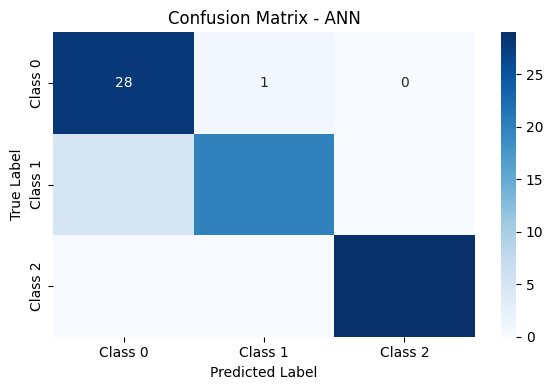

Evaluation metrics for CNN:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   1.000000  0.965517  0.982456  1.000000
1          1.0   0.961538  1.000000  0.980392  0.961538
2          2.0   0.965517  0.965517  0.965517  0.965517
average    NaN   0.976367  0.975904  0.975916  0.975685

[[28  0  1]
 [ 0 25  0]
 [ 0  1 28]]


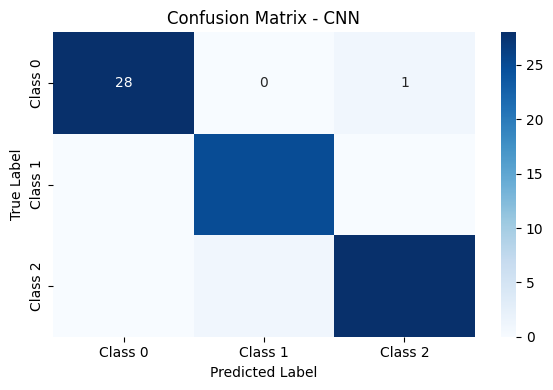

Evaluation metrics for LSTM:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.933333  0.965517  0.949153  0.933333
1          1.0   1.000000  1.000000  1.000000  1.000000
2          2.0   0.964286  0.931034  0.947368  0.964286
average    NaN   0.964228  0.963855  0.963845  0.965873

[[28  0  1]
 [ 0 25  0]
 [ 2  0 27]]


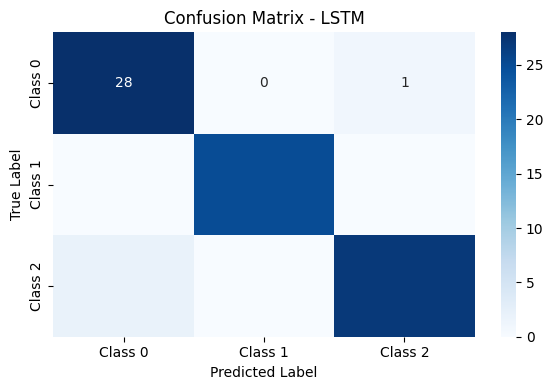

In [14]:
# Define the models and their predictions
models = ['ANN', 'CNN', 'LSTM']
y_preds = [y_pred_ann, y_pred_cnn, y_pred_lstm]

for model, y_pred in zip(models, y_preds):
    # Calculate precision, recall, F1-score, and accuracy per class
    precision_per_class = precision_score(labels_test, y_pred, average=None)
    recall_per_class = recall_score(labels_test, y_pred, average=None)
    f1_per_class = f1_score(labels_test, y_pred, average=None)

    # Calculate accuracy per class
    accuracy_per_class = []
    for class_label in range(len(precision_per_class)):
        correct_predictions = ((y_pred == class_label) & (labels_test == class_label)).sum()
        total_predictions = (y_pred == class_label).sum()
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        accuracy_per_class.append(accuracy)

    # Calculate average precision, recall, F1-score, and accuracy
    avg_precision = precision_score(labels_test, y_pred, average='weighted')
    avg_recall = recall_score(labels_test, y_pred, average='weighted')
    avg_f1 = f1_score(labels_test, y_pred, average='weighted')

    # Create DataFrame for per-class metrics
    results_per_class_df = pd.DataFrame({
        'Class': range(len(precision_per_class)),
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-score': f1_per_class,
        'Accuracy': accuracy_per_class
    })

    # Add average metrics to the DataFrame
    results_per_class_df.loc['average'] = [None, avg_precision, avg_recall, avg_f1, np.mean(accuracy_per_class)]

    print(f"Evaluation metrics for {model}:")
    print(results_per_class_df)
    print()

    # Plot confusion matrix
    cm = confusion_matrix(labels_test, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.tight_layout()
    plt.show()
